# 第５ステージ　DeZeroで挑む

## ステップ52　GPU対応

### 52.1 - 52.4
省略

### 52.5　GPUでMNISTを学習

In [1]:
import time
import leopard
import leopard.functions as F
from leopard import optimizers
from leopard import DataLoader
from leopard.models import MLP

In [2]:
max_epoch = 5
batch_size = 100

train_set = leopard.datasets.MNIST(train=True)
train_loader = DataLoader(train_set, batch_size)
model = MLP((1000, 10))
optimizer = optimizers.SGD().setup(model)

In [3]:
# GPU mode
if leopard.cuda.gpu_enable:
    train_loader.to_gpu()
    model.to_gpu()

In [4]:
for epoch in range(max_epoch):
    start = time.time()
    sum_loss = 0

    for x, t in train_loader:
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        model.cleargrads()
        loss.backward()
        optimizer.update()
        sum_loss += float(loss.data) * len(t)

    elapsed_time = time.time() - start
    print('epoch: {}, loss: {:.4f}, time: {:.4f}[sec]'.format(
        epoch + 1, sum_loss / len(train_set), elapsed_time))

epoch: 1, loss: 1.9258, time: 2.1086[sec]
epoch: 2, loss: 1.2927, time: 1.8631[sec]
epoch: 3, loss: 0.9300, time: 1.8643[sec]
epoch: 4, loss: 0.7425, time: 1.8654[sec]
epoch: 5, loss: 0.6361, time: 1.8707[sec]


試しにCPUモードで学習してみる。

In [5]:
train_loader = DataLoader(train_set, batch_size)
model = MLP((1000, 10))
optimizer = optimizers.SGD().setup(model)

In [6]:
train_loader.to_cpu()
model.to_cpu()

In [7]:
for epoch in range(max_epoch):
    start = time.time()
    sum_loss = 0

    for x, t in train_loader:
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        model.cleargrads()
        loss.backward()
        optimizer.update()
        sum_loss += float(loss.data) * len(t)

    elapsed_time = time.time() - start
    print('epoch: {}, loss: {:.4f}, time: {:.4f}[sec]'.format(
        epoch + 1, sum_loss / len(train_set), elapsed_time))

epoch: 1, loss: 1.9227, time: 4.2091[sec]
epoch: 2, loss: 1.2866, time: 4.0289[sec]
epoch: 3, loss: 0.9242, time: 4.2019[sec]
epoch: 4, loss: 0.7392, time: 4.5182[sec]
epoch: 5, loss: 0.6347, time: 4.3690[sec]


## ステップ53 モデルの保存と読み込み

### 53.1 NumPyのsave関数とload関数
省略

### 53.2 Layerクラスのパラメータをフラットに

In [8]:
import numpy as np

from leopard import Layer
from leopard import Parameter

In [9]:
layer = Layer()

l1 = Layer()
l1.p1 = Parameter(np.array(1))

layer.l1 = l1
layer.p2 = Parameter(np.array(2))
layer.p3 = Parameter(np.array(3))

In [10]:
params_dict = {}
layer._flatten_params(params_dict)
print(params_dict)

{'l1/p1': variable(1), 'p2': variable(2), 'p3': variable(3)}


### 53.3 Layerクラスのsave関数とload関数

In [11]:
import os

In [12]:
max_epoch = 3
batch_size = 100

train_set = leopard.datasets.MNIST(train=True)
train_loader = DataLoader(train_set, batch_size)
model = MLP((1000, 10))
optimizer = optimizers.SGD().setup(model)

In [13]:
# パラメータの読み込み
if os.path.exists('my_mlp.npz'):
    model.load_weights('my_mlp.npz')

In [14]:
for epoch in range(max_epoch):
    sum_loss = 0

    for x, t in train_loader:
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        model.cleargrads()
        loss.backward()
        optimizer.update()
        sum_loss += float(loss.data) * len(t)

    print('epoch: {}, loss: {:.4f}'.format(
        epoch + 1, sum_loss / len(train_set)))

# パラメータの保存
model.save_weights('my_mlp.npz')

epoch: 1, loss: 0.3205
epoch: 2, loss: 0.3189
epoch: 3, loss: 0.3175


## ステップ54　Dropoutとテストモード
例えば、10個のニューロンからなる層があり、その層の次にDropoutレイヤを用いて60%のニューロンをランダムで消去する。つまり、毎回平均して４つの出力だけが次の層へ伝達し、残りは０になる。

In [15]:
dropout_ratio  = 0.6
x = np.ones(10)

mask = np.random.rand(10) > dropout_ratio
print(mask)

y = x * mask
print(y)

[False False  True  True  True  True False False False  True]
[0. 0. 1. 1. 1. 1. 0. 0. 0. 1.]


推論時には、全てのニューロンを使いながら、学習時の挙動を**真似る**必要がある。それには、全てのニューロンを使って計算し、その出力を**弱める**ことで対応できる。<br>

先ほどの例では、学習時平均して40%のニューロンが使用される。それを考慮して、推論時には、全てのニューロンを使って計算し、出力を0.4倍する。

In [16]:
# 学習時
mask = np.random.rand(*x.shape) > dropout_ratio
y = x * mask

# 推論時
scale = 1 - dropout_ratio
y = x * scale

### 54.2　Inverted Dropout
先ほど、**推論時**に`scale`を乗算した。ここで、推論時に何も行わないように、学習時に先回りしてニューロンの値を`1 / scale`倍する。そうすることで主に以下の２つのような利点がある。

1. 推論時の処理速度が少し向上する
2. dropout_ratioを動的に変更できる  

In [17]:
# 学習時
scale = 1 - dropout_ratio
mask = np.random.rand(*x.shape) > dropout_ratio
y = x * mask / scale

# 推論時
y = x

### 54.3 テストモードの追加
Dropoutを使うには、学習と推論のフェーズを判別する必要がある。そこで、逆伝播が不要なモード(`with leopard.no_grad():`)の仕組みを流用する。

### 54.4　Dropoutの実装

In [18]:
from leopard import test_mode

x = np.ones(10)
print(x)

# 学習時
y = F.dropout(x)
print(y)
print(y.sum())

# 推論時
with test_mode():
    y = F.dropout(x)
    print(y)

print(y.sum())

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
variable([0. 0. 2. 2. 0. 0. 0. 0. 0. 2.])
variable(6.0)
variable([1. 1. 1. 1. 1. 1. 1. 1. 1. 1.])
variable(10.0)


## ステップ55　CNNのメカニズム（１）

### 55.1 - 55.4 
省略

### 55.5 出力サイズの計算方法

$$

\rm{out\_shape} = \frac{\rm{input\_shape} + 2 \times \rm{pad} - \rm{kernel\_size}}{\rm{stride}}

$$

In [19]:
from leopard.utils import get_conv_outsize

In [20]:
H, W = 4, 4  # Input size
KH, KW = 3, 3  # Kernel size
SH, SW = 1, 1  # Kernel stride
PH, PW = 1, 1  # Padding size

OH = get_conv_outsize(H, KH, SH, PH)
OW = get_conv_outsize(W, KW, SW, PW)
print(OH, OW)

4 4


## ステップ56　CNNのメカニズム（２）
省略

## ステップ57 conv2d関数とpooling関数
省略

## ステップ58 代表的なCNN(VGG16)

### 58.3 学習済みのVGGを使う

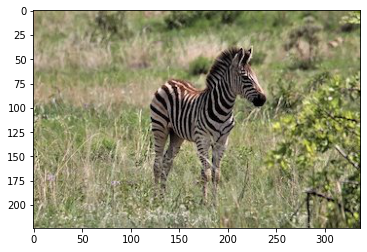

In [21]:
from PIL import Image
import matplotlib.pyplot as plt

url = 'https://github.com/oreilly-japan/deep-learning-from-scratch-3/raw/images/zebra.jpg'
img_path = leopard.utils.get_file(url)
img = Image.open(img_path)
plt.imshow(img)

In [22]:
from leopard.models import VGG16

x = VGG16.preprocess(img)
x = x[np.newaxis] # バッチ用の軸を追加

In [23]:
model = VGG16(pretrained=True)
with leopard.test_mode():
    y = model(x)
predict_id = np.argmax(y.data)

In [24]:
labels = leopard.datasets.ImageNet.labels()
print(labels[predict_id])

zebra


## ステップ59　RNNによる時系列データ処理

### 59.1 RNNレイヤの実装

RNNの順伝播は以下の数式で表される。

$$

\boldsymbol h_t = \tanh (\boldsymbol h_{t-1} W_h + \boldsymbol x_t W_x + \boldsymbol b)

$$

RNNには２つの重みがある。１つ目は、入力$\boldsymbol x$を隠れ状態$\boldsymbol h$に変換するための重み$W_x$である。<br>
２つ目は、１つ前のRNNの出力を次の時刻の出力に変換するための重み$W_h$である。そして、バイアスとして$\boldsymbol b$がある。<br>
なお、ここでは、$\boldsymbol h_{t-1}, \ \boldsymbol x_t$はともに行ベクトルとする。

In [25]:
import leopard.layers as L

In [26]:
rnn = L.RNN(10) # 隠れ層のサイズだけを指定
x = np.random.rand(1, 1)
h = rnn(x)
print(h.shape)

(1, 10)


### 59.2 RNNモデルの実装
省略

### 59.3 「つながり」を切るためのメソッド
省略

### 59.4 サイン波の予測

In [27]:
# Hyperparameters
max_epoch = 100
hidden_size = 100
bptt_length = 30 # BPTTの長さ

train_set = leopard.datasets.SinCurve(train=True)
seqlen = len(train_set)

In [28]:
from leopard.models import SimpleRNN

In [29]:
model = SimpleRNN(hidden_size, 1)
optimizer = leopard.optimizers.Adam().setup(model)

In [30]:
# Start training.
for epoch in range(max_epoch):
    model.reset_state()
    loss, count = 0, 0

    for x, t in train_set:
        x = x.reshape(1, 1) # 形状を(1, 1)へ変換
        y = model(x)
        loss += F.mean_squared_error(y, t)
        count += 1

        # Truncated BPTTのタイミングを調整
        if count % bptt_length == 0 or count == seqlen:
            model.cleargrads()
            loss.backward()
            loss.unchain_backward() # つながりを切る
            optimizer.update()

    avg_loss = float(loss.data) / count
    if epoch % 10 == 0:
        print('| epoch %d | loss %f' % (epoch + 1, avg_loss))

| epoch 1 | loss 0.049603
| epoch 11 | loss 0.002170
| epoch 21 | loss 0.004769
| epoch 31 | loss 0.005781
| epoch 41 | loss 0.088367
| epoch 51 | loss 0.017768
| epoch 61 | loss 0.002786
| epoch 71 | loss 0.007039
| epoch 81 | loss 0.002499
| epoch 91 | loss 0.008776


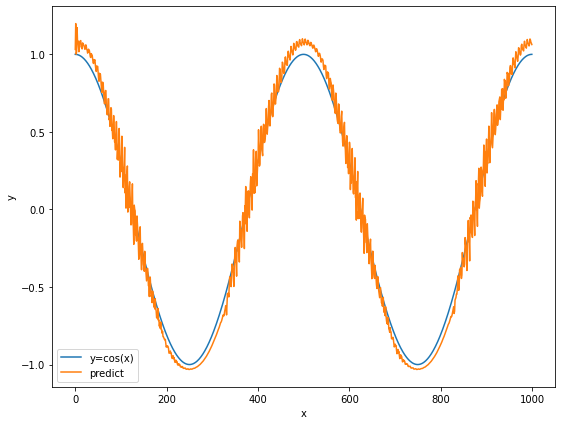

In [31]:
# Plot
xs = np.cos(np.linspace(0, 4 * np.pi, 1000))
model.reset_state() # モデルのリセット
pred_list = []

with leopard.no_grad():
    for x in xs:
        x = np.array(x).reshape(1, 1)
        y = model(x)
        pred_list.append(float(y.data))

plt.figure(figsize=(9, 7))
plt.plot(np.arange(len(xs)), xs, label='y=cos(x)')
plt.plot(np.arange(len(xs)), pred_list, label='predict')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## ステップ60 LSTMとデータローダ

### 60.1 時系列データのためのデータローダ

In [32]:
from leopard.dataloaders import SeqDataLoader

train_set = leopard.datasets.SinCurve(train=True)
dataloader = SeqDataLoader(train_set, batch_size=3)

x, t = next(dataloader)
print(x)
print('-----------------------')
print(t)

[[ 0.00797803]
 [ 0.87122898]
 [-0.83885145]]
-----------------------
[[ 0.04609263]
 [ 0.87190855]
 [-0.83978721]]


### 60.2 LSTMレイヤの実装

LSTMは、RNNに入力ゲート、忘却ゲート、出力ゲートの３つを追加したモデルである。以下がLSTMの数式である。

$$

\begin{aligned}

\boldsymbol f_t &= \sigma (\boldsymbol x_t W_x^{(f)} + \boldsymbol h_{t-1} W_h^{(f)} + \boldsymbol b^{(f)}) \ & \mathrm{forget gate} \\

\boldsymbol i_t &= \sigma (\boldsymbol x_t W_x^{(i)} + \boldsymbol h_{t-1} W_h^{(i)} + \boldsymbol b^{(i)}) \  & \mathrm{input gate} \\

\boldsymbol o_t &= \sigma (\boldsymbol x_t W_x^{(o)} + \boldsymbol h_{t-1} W_h^{(o)} + \boldsymbol b^{(o)}) \  & \mathrm{output gate} \\

\boldsymbol g_t &= \tanh (\boldsymbol x_t W_x^{(g)} + \boldsymbol h_{t-1} W_h^{(g)} + \boldsymbol b^{(g)}) \\

\boldsymbol c_t &= \boldsymbol f_t \odot \boldsymbol c_{t-1} + \boldsymbol i_t \odot \boldsymbol g_t \\

\boldsymbol h_t &= \boldsymbol o_t \odot \tanh (\boldsymbol c_t)

\end{aligned}

$$

In [33]:
max_epoch = 100
batch_size = 30
hidden_size = 100
bptt_length = 30

# 時系列用のデータローダを使用
train_set = leopard.datasets.SinCurve(train=True)
dataloader = SeqDataLoader(train_set, batch_size=batch_size)
seqlen = len(train_set)

In [34]:
from leopard.models import BetterRNN
model = BetterRNN(hidden_size, 1)
optimizer = leopard.optimizers.Adam().setup(model)

In [35]:
for epoch in range(max_epoch):
    model.reset_state()
    loss, count = 0, 0

    for x, t in dataloader:
        y = model(x)
        loss += F.mean_squared_error(y, t)
        count += 1

        if count % bptt_length == 0 or count == seqlen:
            model.cleargrads()
            loss.backward()
            loss.unchain_backward()
            optimizer.update()
    avg_loss = float(loss.data) / count
    if epoch % 10 == 0:
        print('| epoch %d | loss %f' % (epoch + 1, avg_loss))

| epoch 1 | loss 0.044275
| epoch 11 | loss 0.008971
| epoch 21 | loss 0.006753
| epoch 31 | loss 0.004882
| epoch 41 | loss 0.003770
| epoch 51 | loss 0.003351
| epoch 61 | loss 0.002991
| epoch 71 | loss 0.002766
| epoch 81 | loss 0.002574
| epoch 91 | loss 0.002422


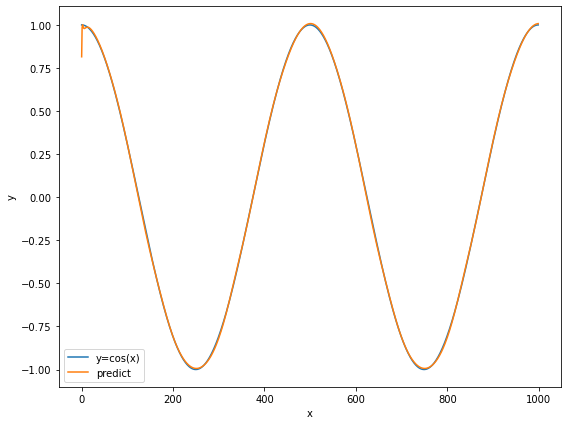

In [36]:
# Plot
xs = np.cos(np.linspace(0, 4 * np.pi, 1000))
model.reset_state()
pred_list = []

with leopard.no_grad():
    for x in xs:
        x = np.array(x).reshape(1, 1)
        y = model(x)
        pred_list.append(float(y.data))

plt.figure(figsize=(9, 7))
plt.plot(np.arange(len(xs)), xs, label='y=cos(x)')
plt.plot(np.arange(len(xs)), pred_list, label='predict')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

# 第５ステージ終了